In [24]:
import pandas as pd
import numpy as np
import os
import pickle

from config import BASE_DIR
print(os.getcwd())
os.chdir(BASE_DIR)
from scripts.backtesting.backtesting import Strategy, Backtest 
from scripts.backtesting.lib import resample_apply
from ta.volatility import BollingerBands
import scripts.functions as fn 

C:\Users\lbisa\Dropbox\Cripto\python\InvestingEvolution\ie\www


In [25]:
klines_file = './backtest/klines/2d01/Completo_BTCUSDT_2d01_2021-01-01_2023-07-31.DataFrame'
#klines_file = './backtest/klines/0m15/Completo_XRPUSDT_0m15_2021-01-01_2023-07-31.DataFrame'
#klines_file  = './backtest/klines/0m01/Completo_BTCUSDT_0m01_2021-01-01_2023-07-31.DataFrame'
#klines_file = './backtest/klines/0m01/Lateral_BTCUSDT_0m01_2023-06-20_2023-10-09.DataFrame'
#klines_file  = './backtest/klines/1h01/Completo_BTCUSDT_1h01_2021-01-01_2023-07-31.DataFrame'
#klines_file = './backtest/klines/1h01/Lateral_BTCUSDT_1h01_2023-06-20_2023-10-09.DataFrame'
#klines_file = './backtest/klines/1h01/Bajista_BTCUSDT_1h01_2021-04-12_2021-07-12.DataFrame'
#klines_file  = './backtest/klines/1h04/Completo_BTCUSDT_1h04_2021-01-01_2023-07-31.DataFrame'

with open(klines_file, 'rb') as file:
    data = pickle.load(file)
    #data.set_index('datetime',inplace=True)


<Axes: >

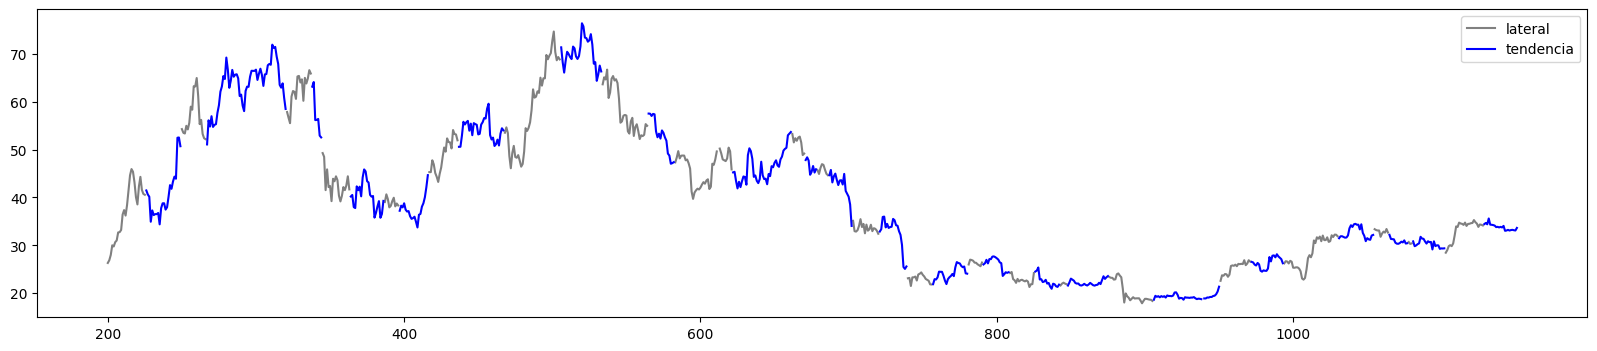

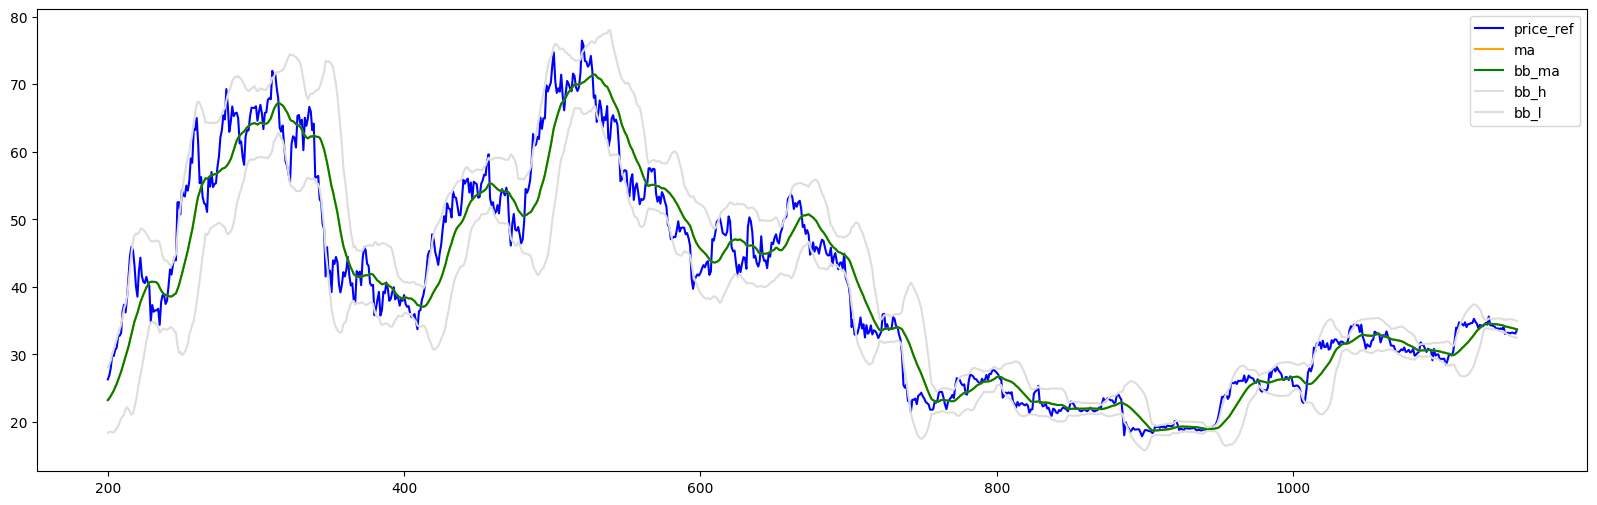

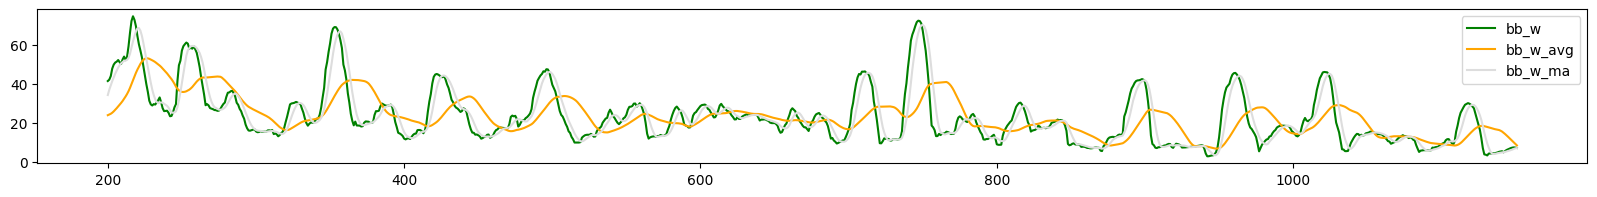

In [26]:
#Calculo de precio de referencia
min_price = data['low'].min()
data['price_ref'] = (data['close']/min_price)*10

#Media movil simple
data['ma'] = data['price_ref'].rolling(20).mean()

#Bollinger
boll = BollingerBands(close=data['price_ref'],window=20,window_dev=2)
data['bb_ma'] = boll.bollinger_mavg()
data['bb_h'] = boll.bollinger_hband()
data['bb_l'] = boll.bollinger_lband()
data['bb_w'] = boll.bollinger_wband()

#Esta info se deberia calcular cada 1 dia/semana y almacenarla en la DB, analizando la amplitud del ultimo año
bb_w_info = data['bb_w'].describe()
#corte para definir si la aplitud es mayor al estandard
#data['bb_w_avg'] = bb_w_info['mean']+bb_w_info['std']
data['bb_w_avg'] = data['bb_w'].rolling(30).mean()


#Media simple de la amplitud
data['bb_w_ma'] = data['bb_w'].rolling(7).mean()

#Analisis de la tendencia
#Si la amplitud supera el corte hay tendencia
data['trend'] = np.where((data['bb_w_avg']>data['bb_w_ma']),1,0)

#Cruce de media simple con la media de la bollinger
data['cross'] = np.where(data['bb_ma']>data['ma'],1,-1)
#Mantiene el cruce de medias neutro mientras trend esta en neutro
data['cross'] = np.where(data['trend']==0,0,data['cross'])

#Transforma la tendencia de acuerdo al cruce de ma
data['trend'] = data['trend']*data['cross']
data['lateral'] = data[data['trend']==0]['price_ref'] 
data['tendencia'] = data[data['trend']!=0]['price_ref'] 

data[200:][['lateral','tendencia']].plot(figsize=(20,4),style=['gray','blue'])
data[200:][['price_ref','ma','bb_ma','bb_h','bb_l']].plot(figsize=(20,6),style=['blue','orange','green','#dddddd','#dddddd'])
data[200:][['bb_w','bb_w_avg','bb_w_ma']].plot(figsize=(20,2),style=['green','orange','#dddddd','#aaaaaa',])

